# Parameter Estimation Methods on Quadrotor Control Tasks

## Import packages

In [181]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
from collections import deque
np.set_printoptions(precision=4, suppress=True)
# Note: autograd does not work with np.block

## Quadrotor Dynamics

In [160]:
#Quaternion stuff, check `Planning with Attitude` paper for more details
def hat(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0.0]])

def L(q):
    s = q[0]
    v = q[1:4]
    up = np.hstack([s, -v])
    down = np.hstack([v.reshape(3,1), s*np.eye(3) + hat(v)])
    L = np.vstack([up,down])
    return L

T = np.diag([1.0, -1, -1, -1])
H = np.vstack([np.zeros((1,3)), np.eye(3)])

def qtoQ(q):
    return H.T @ T @ L(q) @ T @ L(q) @ H

def G(q):
    return L(q) @ H

def rptoq(phi):
    return (1./math.sqrt(1+phi.T @ phi)) * np.hstack([1, phi])

def qtorp(q):
    return q[1:4]/q[0]

def E(q):
    up = np.hstack([np.eye(3), np.zeros((3,3)), np.zeros((3,6))])
    mid = np.hstack([np.zeros((4,3)), G(q), np.zeros((4,6))])
    down = np.hstack([np.zeros((6,3)), np.zeros((6,3)), np.eye(6)])
    E = np.vstack([up, mid, down])
    return E

# Quadrotor parameters
mass = 0.035  # mass
J = np.array([[1.66e-5, 0.83e-6, 0.72e-6], [0.83e-6, 1.66e-5, 1.8e-6], [0.72e-6, 1.8e-6, 2.93e-5]])  # inertia
g = 9.81  # gravity
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008  # thrust to torque ratio
el = 0.046/1.414213562  # arm length
scale = 65535  # PWM scale
kt = 2.245365e-6*scale # thrust coefficient, u is PWM in range [0...1], 0 is no thrust, 1 is max thrust
km = kt*thrustToTorque # moment coefficient

freq = 50.0 
h = 1/freq #50 Hz

Nx1 = 13        # number of states (quaternion)
Nx = 12         # number of states (linearized): x, y, z, Rodriguez 3-parameters (p, q, r), vx, vy, vz, wx, wy, wz
Nu = 4          # number of controls (motor pwm signals, 0-1)

# Quadrotor dynamics -- single rigid body dynamics
def quad_dynamics(x, u, mass, g):
    r = x[0:3]  # position
    q = x[3:7]/norm(x[3:7])  # normalize quaternion
    v = x[7:10]  # linear velocity
    omg = x[10:13]  # angular velocity
    Q = qtoQ(q)  # quaternion to rotation matrix

    dr = v
    dq = 0.5*L(q)@H@omg
    dv = np.array([0, 0, -g]) + (1/mass)*Q@np.array([[0, 0, 0, 0], [0, 0, 0, 0], [kt, kt, kt, kt]])@u
    domg = inv(J)@(-hat(omg)@J@omg + np.array([[-el*kt, -el*kt, el*kt, el*kt], [-el*kt, el*kt, el*kt, -el*kt], [-km, km, -km, km]])@u)
    return np.hstack([dr, dq, dv, domg])

# RK4 integration with zero-order hold on u
def quad_dynamics_rk4(x, u, mass, g):
    f1 = quad_dynamics(x, u, mass, g)
    f2 = quad_dynamics(x + 0.5*h*f1, u, mass, g)
    f3 = quad_dynamics(x + 0.5*h*f2, u, mass, g)
    f4 = quad_dynamics(x + h*f3, u, mass, g)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xnormalized = xn[3:7]/norm(xn[3:7])  # normalize quaternion
    return np.hstack([xn[0:3], xnormalized, xn[7:13]])

# Linearize the dynamics around xg, uhover
A_jac = jacobian(quad_dynamics_rk4, 0)  # jacobian wrt x
B_jac = jacobian(quad_dynamics_rk4, 1)  # jacobian wrt u

## Test Nominal Controller to Hover

In [161]:
# Hovering state and control input
rg = np.array([0.0, 0, 0.0])
qg = np.array([1.0, 0, 0, 0])
vg = np.zeros(3)
omgg = np.zeros(3)
xg = np.hstack([rg, qg, vg, omgg])
uhover = (mass*g/kt/4)*np.ones(4)  # ~each motor thrust to compensate for gravity
print("Hovering Initial State and Control")
print(xg, uhover)

check_grads(quad_dynamics_rk4, modes=['rev'], order=2)(xg, uhover, mass, g)

Anp = A_jac(xg, uhover, mass, g)  # jacobian of the dynamics wrt x at xg, uhover
Bnp = B_jac(xg, uhover, mass, g)  # jacobian of the dynamics wrt u at xg, uhover

# `Planning with Attitude` trick, attitude Jacobians
#  https://rexlab.ri.cmu.edu/papers/planning_with_attitude.pdf
Anp = E(qg).T @ Anp @ E(qg)
Bnp = E(qg).T @ Bnp

# print("A = \n", Anp)
# print("B = \n", Bnp)

# x0[0:3] += rg + 3*np.random.randn(3)/3  # disturbed initial position
x0 = np.copy(xg)
x0[0:3] += rg + np.array([0.2, 0.2, -0.2])  # disturbed initial position
x0[3:7] = rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude
print("Perturbed Intitial State")
print(x0)

Hovering Initial State and Control
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.5833 0.5833 0.5833 0.5833]
Perturbed Intitial State
[ 0.2     0.2    -0.2     0.7071  0.7071  0.      0.      0.      0.
  0.      0.      0.      0.    ]


## Parameter Estimation Methods
### 1. Recursive Least Squares

In [162]:
class NaiveRLS:
    def __init__(self, num_params, lambda_factor=0.97):
        self.num_params = num_params
        self.lambda_factor = lambda_factor
        self.theta = 0.                    # Parameter estimate
        self.P = 1000.                       # Large initial covariance matrix

    def update(self, x, y):
        # Reshape inputs to column vectors
        x = np.reshape(x, (13, 1))          # TODO: 13 is hard coded! Change this
        y = np.reshape(y, (13, 1))          # Compute Kalman gain
        P_x = self.P * x
        gain_denominator = self.lambda_factor + x.T @ P_x
        K = P_x / gain_denominator        # Update estimate
        y_pred = x * self.theta
        self.theta = self.theta + K.T @ (y - y_pred)        # Update covariance matrix
        self.P = (self.P - K.T @ x * self.P) / self.lambda_factor
        return self.theta

### 2. Extended Kalman Filter

In [5]:
class EKF:
    def __init__(self, process_noise=1e-3, measurement_noise=1e-1):
        self.theta =0.                    # Initial gravity estimate
        self.P = 100.0                       # Initial covariance
        self.Q = process_noise                # Process noise covariance
        self.R = np.eye(13) * measurement_noise  # Measurement noise covariance

    def predict(self):
        # Prediction step
        self.P = self.P + self.Q

    def update(self, x, y):
        """
        x: 13x1 Jacobian vector (sensitivity of dynamics to gravity)
        y: 13x1 observation vector (state differences)
        """
        # Ensure x and y are column vectors
        x = np.reshape(x, (13, 1))
        y = np.reshape(y, (13, 1))
        print(x,y)
        # Innovation covariance
        S = (x @ (self.P * x.T)) + self.R
        # Kalman gain
        K = (self.P * x.T) @ np.linalg.inv(S)  # K is 1x13

        # Update state estimate
        self.theta = self.theta + (K @ y).item()
        print(self.theta)
        # Update covariance
        self.P = self.P - (K @ S @ K.T).item()
        return self.theta

### 3. Randomized Kaczmarz Method

In [6]:
class RK:
    def __init__(self, alpha=1.):
        self.alpha = alpha

    def iterate(self, A, b, x0, num_iterations, tol = 1e-5):
        self.A = A
        self.b = b
        self.n = A.shape[0]  # m is the number of rows, n is the number of columns
        self.x = x0  # Initial estimate of solution

        for _ in range(num_iterations):
            # Compute exponential weighting for the rows
            col_indices = np.arange(self.n)
            exp_weights = np.exp(-self.alpha * (self.n - col_indices))
            probabilities = exp_weights / np.sum(exp_weights)     # Normalize to make it a valid probability distribution
            i = np.random.choice(self.n, p = probabilities)            # Update rule using the selected row

            a_i = self.A[i]
            b_i = self.b[i]

            residual = np.abs(b_i - a_i*self.x)
            if residual.sum() < tol:
                break
            # import pdb
            # pdb.set_trace()

            if a_i.item() == 0:
                continue

            self.x = self.x + ((b_i - a_i*self.x) / (np.linalg.norm(a_i)**2)) * a_i


        return self.x.item()



In [163]:
class RK_v2:
    def __init__(self, alpha=0.99):
        self.alpha = alpha

    def iterate(self, A, b, x0, num_iterations, tol = 0.01):
        """
        A: (num_states, num_param)
        x: (num_param, 1)
        b: (num_states, 1)
        """
        self.A = A
        self.b = b
        self.m = A.shape[0]  # m is the number of rows, n is the number of columns
        self.n = A.shape[1]
        self.x = np.array([x0]).reshape(self.n,1)  # Initial estimate of solution
        # print("cond: ",np.linalg.cond(A))
        # print("A: ", self.A)
        # print("b: ", self.b)
        # print("x0: ", self.x)
        for _ in range(num_iterations):
            # Compute exponential weighting for the rows
            row_norms = np.linalg.norm(A,axis=1)**2
            # probabilities = row_norms / np.sum(row_norms)
            mask = (row_norms > 1e-6)
            # print(mask)
            exponential_weights = mask * np.exp(self.alpha * row_norms)
            probabilities = exponential_weights / (np.sum(exponential_weights))
            i = np.random.choice(self.m, p = probabilities)            # Update rule using the selected row
            # print(i)
            #print(i)
            a_i = np.array(self.A[i]) #.reshape(13,1)
            b_i = np.array(self.b[i])#.reshape(1,13)
            residual = np.dot(self.A, self.x) - b
            # print("A: ", self.A)
            # print("b", self.b)
            # print("residual size: ", np.abs(residual).sum())
            if np.abs(residual).sum()/self.m < tol:
                print("tolerance hit")
                break
            increment = ((b_i - np.dot(a_i,self.x)) / (np.linalg.norm(a_i)**2))*a_i
            increment = increment.reshape(self.n,1)

            self.x = self.x + increment
        return self.x

### Some Auxiliary Methods

In [164]:
def df_dg(x, u, mass, g, h=1e-5):
    f_g = quad_dynamics_rk4(x, u, mass, g)

    f_g_plus_h = quad_dynamics_rk4(x, u, mass, g+h)

    df_dg = (f_g_plus_h - f_g) / h

    return df_dg

def df_dmg(x, u, mass, g, h=1e-5):
    f_mg = quad_dynamics_rk4(x, u, mass, g).reshape(-1,1)
    f_g_plus_h = quad_dynamics_rk4(x, u, mass, g+h).reshape(-1,1) # (13,1)
    f_m_plus_h = quad_dynamics_rk4(x, u, mass+h, g).reshape(-1,1) # (13,1)
    df_dmg = np.hstack(((f_g_plus_h - f_mg) / h, (f_m_plus_h - f_mg) / h)) # (13,2)

    return df_dmg

# function to visualize the trajectory
def visualize_trajectory_with_theta(x_all, u_all, theta_hat_all, theta_all, title):
    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(3, 1)

    # Plot the trajectory
    x_all = np.array(x_all)
    nsteps = len(x_all)
    steps = np.arange(nsteps)
    ax[0].plot(steps, x_all[:, 0], label="x", linewidth=2)
    ax[0].plot(steps, x_all[:, 1], label="y", linewidth=2)
    ax[0].plot(steps, x_all[:, 2], label="z", linewidth=2)
    ax[0].legend()
    ax[0].title.set_text("Position")


    theta_all = np.array(theta_all)
    theta_hat_all = np.array(theta_hat_all)
    nsteps = len(theta_all)
    steps = np.arange(nsteps)
    ax[1].plot(steps, theta_all, label="theta", linewidth=2)
    ax[1].plot(steps, theta_hat_all, label="theta_hat", linewidth=2)
    ax[1].legend()
    ax[1].title.set_text("Param Estimates")

    # ax[2].plot(steps, x_all[:, 3], label="q0", linewidth=2)
    # ax[2].plot(steps, x_all[:, 4], label="q1", linewidth=2)
    # ax[2].plot(steps, x_all[:, 5], label="q2", linewidth=2)
    # ax[2].plot(steps, x_all[:, 6], label="q3", linewidth=2)
    # ax[2].legend()
    # ax[2].title.set_text("Attitude")

    u_all = np.array(u_all)
    nsteps = len(u_all)
    steps = np.arange(nsteps)
    ax[2].plot(steps, u_all[:, 0], label="u1", linewidth=2)
    ax[2].plot(steps, u_all[:, 1], label="u2", linewidth=2)
    ax[2].plot(steps, u_all[:, 2], label="u3", linewidth=2)
    ax[2].plot(steps, u_all[:, 3], label="u4", linewidth=2)
    # ax[2].legend()
    ax[2].title.set_text("Controls")

    plt.suptitle(title)
    plt.show()

def visualize_trajectory(x_all, u_all, title):
    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(2, 1)

    # Plot the trajectory
    x_all = np.array(x_all)
    nsteps = len(x_all)
    steps = np.arange(nsteps)
    ax[0].plot(steps, x_all[:, 0], label="x", linewidth=2)
    ax[0].plot(steps, x_all[:, 1], label="y", linewidth=2)
    ax[0].plot(steps, x_all[:, 2], label="z", linewidth=2)
    ax[0].legend()
    ax[0].title.set_text("Position")

    u_all = np.array(u_all)
    nsteps = len(u_all)
    steps = np.arange(nsteps)
    ax[1].plot(steps, u_all[:, 0], label="u1", linewidth=2)
    ax[1].plot(steps, u_all[:, 1], label="u2", linewidth=2)
    ax[1].plot(steps, u_all[:, 2], label="u3", linewidth=2)
    ax[1].plot(steps, u_all[:, 3], label="u4", linewidth=2)
    # ax[1].legend()
    ax[1].title.set_text("Controls")

    plt.suptitle(title)
    plt.show()

### Simulating hover task with different parameter estimation methods in MPC

In [165]:
def simulate_with_controller_naive_MPC(x0, x_nom, u_nom, controller, NSIM = 200):
    x_all = []
    u_all = []
    x_curr = np.copy(x0)

    mass = 0.035
    g = 9.81

    change_params = False

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        # change mass
        if i == 50:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g
            u_nom_new = (mass*g_new/kt/4)*np.ones(4)

        # MPC controller
        if i >= 60:
            u_curr = controller(x_curr, x_nom, u_nom_new)
        else:
            u_curr = controller(x_curr, x_nom, u_nom)

        print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr[:3])

        # postponing the dynamics model by telling it the correct parameters after several steps
        if change_params:
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
        else:
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
    return x_all, u_all

In [166]:
def simulate_with_controller_RLS(x0, x_nom, u_nom, controller, NSIM = 300):
    # TODO: change variables, add comments
    x_all = []
    u_all = []
    theta_all = []
    theta_hat_all = []
    x_curr = np.copy(x0)

    # initialize
    mass = 0.035
    g0 = 9.81
    g_hat = 9.81

    change_params = False
    u_curr = np.array([1.2837, 1.0766, 0.1413, 0.152])

    rls = NaiveRLS(num_params=1)

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        # change mass
        if i == 50:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g0

        # MPC controller
        u_nom = (mass*g_hat/kt/4)*np.ones(4)

        u_prev = u_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr[:3])

        if change_params:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
            theta_all.append(g_new)
        else:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g0)
            theta_all.append(g0)

        df_dg_at_g0 = df_dg(x_prev, u_prev, mass, g0)

        f_at_g0 = quad_dynamics_rk4(x_prev, u_prev, mass, g0)

        x_curr_hat = f_at_g0 + df_dg_at_g0 * (g_hat - g0)

        b = x_curr - f_at_g0 + df_dg_at_g0 * g0

        print("A: ", df_dg_at_g0)
        print("b: ", b)
        print("g_hat", g_hat)

        # print("Ax-b: ", df_dg_at_g0 * g_hat - b)

        g_hat = rls.update(df_dg_at_g0, b).item()

        # if change_params:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g_new)
        # else:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g0)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
        theta_hat_all.append(g_hat)
    return x_all, u_all, theta_hat_all, theta_all

In [167]:
def simulate_with_controller_RK(x0, x_nom, u_nom, controller, NSIM = 200):
    x_all = []
    u_all = []
    theta_all = []
    theta_hat_all = []
    x_curr = np.copy(x0)

    # initialize
    mass = 0.035
    g0 = 9.81
    g_hat = 9.81

    change_params = False
    u_curr = controller(x0, x_nom, u_nom)

    rk = RK_v2()

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        # change mass
        if i == 50:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g0

        # MPC controller
        u_nom = (mass*g_hat/kt/4)*np.ones(4)
        u_prev = u_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr[:3])

        if change_params:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
            theta_all.append(g_new)
            x0 = g_hat
        else:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g0)
            theta_all.append(g0)
            x0 = g_hat

        # taylor exp
        df_dg_at_g0 = df_dg(x_prev, u_prev, mass, g0)
        f_at_g0 = quad_dynamics_rk4(x_prev, u_prev, mass, g0)
        x_curr_hat = f_at_g0 + df_dg_at_g0 * (g_hat - g0)
        b = (x_curr - f_at_g0 + df_dg_at_g0 * g0)

        if i == 0 or i == 60:
            b_all = b.reshape(13,1)
            df_dg_all = df_dg_at_g0.reshape(13,1)
        if i >= 1:
            # import pdb
            # pdb.set_trace()
            b_all = np.vstack((b_all, b.reshape(13,1)))
            df_dg_all = np.vstack((df_dg_all, df_dg_at_g0.reshape(13,1)))
            g_hat = rk.iterate(df_dg_all, b_all, x0, 1000).item()

        # print("A: ", df_dg_at_g0)
        # print("b: ", b)
        if change_params:
            print("residual: ", np.abs(df_dg_all * g_new - b_all).sum())
        else:
            print("residual: ", np.abs(df_dg_all * g0 - b_all).sum())

        print("A:" , df_dg_at_g0)
        print("b: ", b)

        if change_params:
            print("step: ", i, "guess: ", g_hat, "gt: ", g_new)
        else:
            print("step: ", i, "guess: ", g_hat, "gt: ", g0)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
        theta_hat_all.append(g_hat)
    return x_all, u_all, theta_hat_all, theta_all

### Test LQR Controller to Hover

In [168]:
# Choose Q and R matrices based on Bryson's rule
max_dev_x = np.array([0.1, 0.1, 0.1,  0.5, 0.5, 0.05,  0.5, 0.5, 0.5,  0.7, 0.7, 0.2])
max_dev_u = np.array([0.5, 0.5, 0.5, 0.5])/6
Q = np.diag(1./max_dev_x**2)
R = np.diag(1./max_dev_u**2)

# Riccati recursion on the linearized dynamics
def dlqr(A, B, Q, R, n_steps = 500):
    P = Q
    for i in range(n_steps):
        K = inv(R + B.T @ P @ B) @ B.T @ P @ A
        P = Q + A.T @ P @ (A - B @ K)
    return K, P

K_lqr, P_lqr = dlqr(Anp, Bnp, Q, R)
# print("K LQR = \n", K_lqr)

# Drive the system from initial state to the hovering state using the LQR controller:
# LQR controller, input is 13x1 state vector
def delta_x_quat(x_curr):
    q = x_curr[3:7]
    phi = qtorp(L(qg).T @ q)
    delta_x = np.hstack([x_curr[0:3]-rg, phi, x_curr[7:10]-vg, x_curr[10:13]-omgg])
    return delta_x
def lqr_controller(x_curr, u_nom):
    delta_x = delta_x_quat(x_curr)
    return u_nom - K_lqr @ delta_x

In [169]:
# title = "g *= 2 at t=50 & not telling controller"
# title = "g *= 2 at t=50 and telling the controller immediately"
# title = "g *= 2 at t=50 and telling the controller 10 steps after"
# x_lqr, u_lqr = simulate_with_controller_naive_MPC(x0, xg, uhover, lqr_controller)
# visualize_trajectory(x_lqr, u_lqr, title)

# title = "RLS: g *= 2 at t = 50"
# x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_RLS(x0, xg, uhover, lqr_controller)
# visualize_trajectory(x_lqr, u_lqr, theta_hat, theta, title)

title = "KM: g *= 2 at t = 50"
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_RK(x0, xg, uhover, lqr_controller)
visualize_trajectory(x_lqr, u_lqr, theta_hat, theta, title)

TypeError: lqr_controller() takes 2 positional arguments but 3 were given

### Simulate Tracking Task with different parameter estimation methods in MPC

In [170]:
def simulate_with_controller_naive_MPC(x0, x_nom_lower, u_nom, controller, traj, update_status, NSIM = 600):
    x_all = []
    u_all = []
    x_curr = np.copy(x0)

    mass = 0.035
    g = 9.81

    changing_step = 100
    change_params = False

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        x_nom = np.hstack([traj[i], x_nom_lower])
        # change mass
        if i == changing_step:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g
            u_nom_new = (mass*g_new/kt/4)*np.ones(4)

        # MPC controller
        if update_status == "immediately_update":
            if i >= changing_step:
                u_curr = controller(x_curr, x_nom, u_nom_new)
            else:
                u_curr = controller(x_curr, x_nom, u_nom)
        elif update_status == "never_update":
            u_curr = controller(x_curr, x_nom, u_nom)
        elif update_status == "late_update":
            if i >= changing_step + 10:
                u_curr = controller(x_curr, x_nom, u_nom_new)
            else:
                u_curr = controller(x_curr, x_nom, u_nom)

        # print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr[:3])

        # postponing the dynamics model by telling it the correct parameters after several steps
        if change_params:
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
        else:
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
    return x_all, u_all

In [171]:
def simulate_with_controller_RLS(x0, x_nom_lower, u_nom, controller, traj, NSIM = 600):
    # TODO: change variables, add comments
    x_all = []
    u_all = []
    theta_all = []
    theta_hat_all = []
    x_curr = np.copy(x0)

    # initialize
    mass = 0.035
    g0 = 9.81
    g_hat = 9.81

    changing_step = 100
    change_params = False
    u_curr = np.array([1.2837, 1.0766, 0.1413, 0.152])

    rls = NaiveRLS(num_params=1)

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        x_nom = np.hstack([traj[i], x_nom_lower])
        # change mass
        if i == changing_step:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g0

        # MPC controller
        u_nom = (mass*g_hat/kt/4)*np.ones(4)

        u_prev = u_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr[:3])

        if change_params:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
            theta_all.append(g_new)
        else:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g0)
            theta_all.append(g0)

        df_dg_at_g0 = df_dg(x_prev, u_prev, mass, g0)

        f_at_g0 = quad_dynamics_rk4(x_prev, u_prev, mass, g0)

        x_curr_hat = f_at_g0 + df_dg_at_g0 * (g_hat - g0)

        b = x_curr - f_at_g0 + df_dg_at_g0 * g0

        # print("A: ", df_dg_at_g0)
        # print("b: ", b)
        # print("g_hat", g_hat)

        # print("Ax-b: ", df_dg_at_g0 * g_hat - b)

        g_hat = rls.update(df_dg_at_g0, b).item()

        # if change_params:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g_new)
        # else:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g0)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
        theta_hat_all.append(g_hat)
    return x_all, u_all, theta_hat_all, theta_all

In [172]:
def simulate_with_controller_RK(x0, x_nom_lower, u_nom, controller, traj, NSIM = 600):
    x_all = []
    u_all = []
    theta_all = []
    theta_hat_all = []
    x_curr = np.copy(x0)

    # initialize
    mass = 0.035
    g0 = 9.81
    g_hat = 9.81
    g_hat_prev = g0

    changing_step = 100
    change_params = False
    clear_history = False
    x_nom = np.hstack([traj[0], x_nom_lower])
    u_curr = controller(x0, x_nom, u_nom)

    rk = RK_v2()

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        x_nom = np.hstack([traj[i], x_nom_lower])
        # change mass
        if i == changing_step:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g0

        # MPC controller
        u_nom = (mass*g_hat/kt/4)*np.ones(4)
        u_prev = u_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr[:3])

        if change_params:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
            theta_all.append(g_new)
            x0 = g_hat
        else:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g0)
            theta_all.append(g0)
            x0 = g_hat

        # taylor exp
        df_dg_at_g0 = df_dg(x_prev, u_prev, mass, g0)
        f_at_g0 = quad_dynamics_rk4(x_prev, u_prev, mass, g0)
        x_curr_hat = f_at_g0 + df_dg_at_g0 * (g_hat - g0)
        b = (x_curr - f_at_g0 + df_dg_at_g0 * g0)

        if i == 0 or clear_history:
            b_all = b.reshape(13,1)
            df_dg_all = df_dg_at_g0.reshape(13,1)
            clear_history = False
            g_hat_prev = g_hat

        elif i >= 1:
            # import pdb
            # pdb.set_trace()
            b_all = np.vstack((b_all, b.reshape(13,1)))
            df_dg_all = np.vstack((df_dg_all, df_dg_at_g0.reshape(13,1)))
            g_hat_prev = g_hat
            g_hat = rk.iterate(df_dg_all, b_all, x0, 1000, 0.01).item()

        if (g_hat > 1.5 * g_hat_prev):
            print("history cleared at ", i, " b/c the two guesses are ", g_hat, g_hat_prev)
            clear_history = True

        # print("A: ", df_dg_at_g0)
        # print("b: ", b)
        # if change_params:
        #     print("residual: ", np.abs(df_dg_all * g_new - b_all).sum())
        # else:
        #     print("residual: ", np.abs(df_dg_all * g0 - b_all).sum())

        # print("A:" , df_dg_at_g0)
        # print("b: ", b)

        # if change_params:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g_new)
        # else:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g0)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
        theta_hat_all.append(g_hat)
    return x_all, u_all, theta_hat_all, theta_all

In [173]:
def entropy_score(df_dg_window, b_window):
    """
    Compute entropy-based score for a given window of (df_dg, b).
    Lower entropy means a more informative motion sample.
    """
    import pdb; pdb.set_trace()
    # Convert deque lists into proper numpy arrays
    df_dg_window = np.vstack(df_dg_window)  # Shape (num_samples, 13)
    b_window = np.vstack(b_window)  # Shape (num_samples, 13)

    # Ensure they are 2D before stacking
    if df_dg_window.ndim == 1:
        df_dg_window = df_dg_window.reshape(-1, 1)
    if b_window.ndim == 1:
        b_window = b_window.reshape(-1, 1)

    # Stack and ensure it's 2D
    stacked_data = np.hstack((df_dg_window, b_window))  # Shape (num_samples, 26)
    cov_matrix = np.cov(stacked_data, rowvar=False)  # Compute covariance matrix

    # Compute entropy as log determinant of covariance matrix
    entropy = 0.5 * np.linalg.slogdet(cov_matrix)[1]
    return entropy


def simulate_with_controller_entropy_RK(x0, x_nom_lower, u_nom, controller, traj, NSIM=600):
    x_all, u_all, theta_all, theta_hat_all = [], [], [], []
    x_curr = np.copy(x0)

    # Initialize parameters
    mass = 0.035
    g0, g_hat, g_hat_prev = 9.81, 9.81, 9.81

    changing_step = 100
    change_params, clear_history = False, False
    x_nom = np.hstack([traj[0], x_nom_lower])
    u_curr = controller(x0, x_nom, u_nom)

    rk = RK_v2()

    # Priority queue for history (fixed size)
    queue_size = 5
    df_dg_queue, b_queue = deque(maxlen=queue_size), deque(maxlen=queue_size)

    # Keep track of scores for removal
    score_queue = deque(maxlen=queue_size)

    # Simulation loop
    for i in range(NSIM):
        x_nom = np.hstack([traj[i], x_nom_lower])

        # Change system parameters at specific step
        if i == changing_step:
            change_params = True
            g_new = 2 * g0

        # Compute control
        u_nom = (mass * g_hat / kt / 4) * np.ones(4)
        u_prev, x_prev = u_curr, x_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # Simulate dynamics
        if change_params:
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
            theta_all.append(g_new)
            x0 = g_hat
        else:
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g0)
            theta_all.append(g0)
            x0 = g_hat

        # Compute updates for g_hat
        df_dg_at_g0 = df_dg(x_prev, u_prev, mass, g0)
        f_at_g0 = quad_dynamics_rk4(x_prev, u_prev, mass, g0)
        x_curr_hat = f_at_g0 + df_dg_at_g0 * (g_hat - g0)
        b = (x_curr - f_at_g0 + df_dg_at_g0 * g0)

        if i == 0:
            g_hat_prev = g_hat
        else:
            # Calculate score for new data point
            new_score = entropy_score([df_dg_at_g0.reshape(13,1)], [b.reshape(13,1)])

            # Add new data to the queues
            df_dg_queue.append(df_dg_at_g0.reshape(13, 1))
            b_queue.append(b.reshape(13, 1))
            score_queue.append(new_score)

            # Remove oldest data point if queue exceeds maxlen and criteria met
            if len(df_dg_queue) > queue_size:
                # Remove the least informative element based on score if not drastic
                worst_index = np.argmax(score_queue)

                del df_dg_queue[worst_index]
                del b_queue[worst_index]
                del score_queue[worst_index]

            g_hat_prev = g_hat
            g_hat = rk.iterate(np.vstack(df_dg_queue), np.vstack(b_queue), x0, 1000, 0.01).item()

        # Store results
        x_all.append(x_curr.tolist())
        u_all.append(u_curr.tolist())
        theta_hat_all.append(g_hat)

    return x_all, u_all, theta_hat_all, theta_all

In [174]:
def simulate_with_controller_entropy_RK_multi_heuristic_test(x0, x_nom_lower, u_nom, controller, traj, NSIM=600):
    x_all, u_all, theta_all, theta_hat_all = [], [], [], []
    x_curr = np.copy(x0)

    # Initialize parameters
    theta_gt = np.array([[0.035], [9.81]]) # [mass, gravity] (2,)
    theta_hat = theta_gt.copy()
    theta_hat_prev = theta_gt.copy()
    
    changing_step = 100
    change_params, clear_history = False, False
    x_nom = np.hstack([traj[0], x_nom_lower])
    u_curr = controller(x0, x_nom, u_nom)

    rk = RK_v2()

    # Priority queue for history (fixed size)
    queue_size = 5
    df_dg_queue, b_queue = deque(maxlen=queue_size), deque(maxlen=queue_size)

    # Keep track of scores for removal
    score_queue = deque(maxlen=queue_size)

    # Simulation loop
    for i in range(NSIM):
        x_nom = np.hstack([traj[i], x_nom_lower])

        # Change system parameters at specific step
        if i == changing_step:
            change_params = True
            theta_gt = np.array([[0.035], [2*9.81]])

        # Compute control
        u_nom = (theta_hat[0][0] * theta_hat[1][0] / kt / 4) * np.ones(4)
        u_prev, x_prev = u_curr, x_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # Simulate dynamics
        x_curr = quad_dynamics_rk4(x_curr, u_curr, theta_gt[0][0], theta_gt[1][0])
        theta_all.append(theta_gt[1][0])

        # Compute updates for g_hat
        dfdtheta_at_theta_prev = df_dmg(x_prev, u_prev, theta_hat_prev[0][0], theta_hat_prev[1][0]) # shape: (num_states, num_params)
        f_at_theta_prev = quad_dynamics_rk4(x_prev, u_prev, theta_hat_prev[0][0], theta_hat_prev[1][0]) 
        b = (x_curr.reshape(-1,1) - f_at_theta_prev.reshape(-1,1) + np.dot(dfdtheta_at_theta_prev, theta_hat_prev)) # shape: (num_states,1) 

        if i % 50 == 0:
            b_all = b
            dfdtheta_at_theta_prev_all = dfdtheta_at_theta_prev

        else:
            b_all = np.vstack((b_all, b))

            dfdtheta_at_theta_prev_all = np.vstack((dfdtheta_at_theta_prev_all, dfdtheta_at_theta_prev.reshape(-1,2)))
            print("A: ", dfdtheta_at_theta_prev_all)
            print("b:", b_all)
            theta_hat = rk.iterate(dfdtheta_at_theta_prev_all, b_all, theta_hat_prev, 1000, 0.001)
            lsq_soln, residuals, rank, s = np.linalg.lstsq(dfdtheta_at_theta_prev_all, b_all, rcond=None)
            print("km soln: ", theta_hat)
            print("lsq soln: ", lsq_soln)
            import pdb; pdb.set_trace()

            # theta_hat_prev = theta_hat
            # print(np.vstack(df_dg_queue).shape)
            # theta_hat = rk.iterate(np.vstack(df_dg_queue), np.vstack(b_queue), theta_hat_prev, 1000, 0.01)

        # Store results
        x_all.append(x_curr.tolist())
        u_all.append(u_curr.tolist())
        theta_hat_all.append(theta_hat[1][0])

    return x_all, u_all, theta_hat_all, theta_all

In [175]:
def entropy_score_2D(df_dg_window, b_window):
    """
    Compute entropy-based score for a single pair of (df_dg, b) windows.
    Handles inputs where df_dg_window has shape (13, 2)
    and b_window has shape (13, 1).
    """
    import pdb; pdb.set_trace()
    # Flatten the inputs: (13, 2) -> (26,) and (13, 1) -> (13,)
    df_dg_flat = df_dg_window.flatten()  # Shape (26,)
    b_flat = b_window.flatten()  # Shape (13,)

    # Combine the flattened arrays
    combined_data = np.hstack((df_dg_flat, b_flat))  # Shape (39,)

    # Compute covariance matrix
    cov_matrix = np.cov(combined_data, rowvar=False)  # Single sample cov; ensures numeric stability

    # Compute entropy as log determinant of covariance matrix
    entropy = 0.5 * np.log(np.linalg.det(cov_matrix + 1e-6 * np.eye(cov_matrix.shape[0])))
    return entropy

def simulate_with_controller_entropy_RK_multi(x0, x_nom_lower, u_nom, controller, traj, NSIM=600):
    x_all, u_all, theta_all, theta_hat_all = [], [], [], []
    x_curr = np.copy(x0)

    # Initialize parameters
    theta_gt = np.array([[0.035], [9.81]]) # [mass, gravity] (2,)
    theta_hat = theta_gt.copy()
    theta_hat_prev = theta_gt.copy()
    
    changing_step = 100
    change_params, clear_history = False, False
    x_nom = np.hstack([traj[0], x_nom_lower])
    u_curr = controller(x0, x_nom, u_nom)

    rk = RK_v2()

    # Priority queue for history (fixed size)
    queue_size = 5
    df_dg_queue, b_queue = deque(maxlen=queue_size), deque(maxlen=queue_size)

    # Keep track of scores for removal
    score_queue = deque(maxlen=queue_size)

    # Simulation loop
    for i in range(NSIM):
        x_nom = np.hstack([traj[i], x_nom_lower])

        # Change system parameters at specific step
        if i == changing_step:
            change_params = True
            theta_gt = np.array([[0.035], [2*9.81]])

        # Compute control
        u_nom = (theta_hat[0][0] * theta_hat[1][0] / kt / 4) * np.ones(4)
        u_prev, x_prev = u_curr, x_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # Simulate dynamics
        x_curr = quad_dynamics_rk4(x_curr, u_curr, theta_gt[0][0], theta_gt[1][0])
        theta_all.append(theta_gt[1][0])

        # Compute updates for g_hat
        dfdtheta_at_theta_prev = df_dmg(x_prev, u_prev, theta_hat_prev[0][0], theta_hat_prev[1][0]) # shape: (num_states, num_params)
        f_at_theta_prev = quad_dynamics_rk4(x_prev, u_prev, theta_hat_prev[0][0], theta_hat_prev[1][0]) 
        b = (x_curr.reshape(-1,1) - f_at_theta_prev.reshape(-1,1) + np.dot(dfdtheta_at_theta_prev, theta_hat_prev)) # shape: (num_states,1) 

        if i == 0:
            theta_hat_prev = theta_hat
        else:
            # Calculate score for new data point
            new_score = entropy_score_2D(dfdtheta_at_theta_prev, b)

            # Add new data to the queues
            df_dg_queue.append(dfdtheta_at_theta_prev)
            b_queue.append(b)
            score_queue.append(new_score)

            # Remove oldest data point if queue exceeds maxlen and criteria met
            if len(df_dg_queue) > queue_size:
                # Remove the least informative element based on score if not drastic
                worst_index = np.argmax(score_queue)

                del df_dg_queue[worst_index]
                del b_queue[worst_index]
                del score_queue[worst_index]

            theta_hat_prev = theta_hat
            print(np.vstack(df_dg_queue).shape)
            theta_hat = rk.iterate(np.vstack(df_dg_queue), np.vstack(b_queue), theta_hat_prev, 1000, 0.01)

        # Store results
        x_all.append(x_curr.tolist())
        u_all.append(u_curr.tolist())
        theta_hat_all.append(theta_hat[1][0])

    return x_all, u_all, theta_hat_all, theta_all

In [177]:
title = "Entropy KM: m, g *= 2 at t = 100"
# x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_entropy_RK_multi(x0, xg, uhover, lqr_controller, circle_traj)
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_entropy_RK_multi_heuristic_test(x0, xg, uhover, lqr_controller, circle_traj)
visualize_trajectory_with_theta(x_lqr, u_lqr, theta_hat, theta, title)

TypeError: lqr_controller() takes 2 positional arguments but 3 were given

In [27]:
def simulate_with_controller_EKF(x0, x_nom_lower, u_nom, controller, traj, NSIM = 600):
    x_all = []
    u_all = []
    theta_all = []
    theta_hat_all = []
    x_curr = np.copy(x0)

    # initialize
    mass = 0.035
    g0 = 9.81
    g_hat = 0
    dg = 0
    g1=9.81

    changing_step = 100
    change_params = False
    u_curr = np.array([1.2837, 1.0766, 0.1413, 0.152])

    ekf = EKF()

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        x_nom = np.hstack([traj[i], x_nom_lower])
        # change mass
        if i == changing_step:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g0

        # MPC controller
        u_nom = (mass*g_hat/kt/4)*np.ones(4)

        u_prev = u_curr
        u_curr = controller(x_curr, x_nom, u_nom)

        # print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr[:3])

        if change_params:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g_new)
            theta_all.append(g_new)
        else:
            x_prev = x_curr
            x_curr = quad_dynamics_rk4(x_curr, u_curr, mass, g0)
            theta_all.append(g0)

        df_dg_at_g0 = df_dg(x_prev, u_prev, mass, g0)

        x_curr_hat = quad_dynamics_rk4(x_prev, u_prev, mass, g0) + df_dg_at_g0 * dg

        dx_prime = x_curr - x_curr_hat
        dg = ekf.update(df_dg_at_g0, dx_prime)
        print("dg= ",dg)
        g_hat = (dg + g1)
        #print(g_hat)

        # if change_params:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g_new)
        # else:
        #     print("step: ", i, "guess: ", g_hat, "gt: ", g0)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
        theta_hat_all.append(g_hat)
    return x_all, u_all, theta_hat_all, theta_all

### Test LQR Controller to Track Trajectory

In [179]:
# uniformly sample trajectory around a circle
num_points = 600
angles = np.linspace(0, 6*np.pi, num_points, endpoint=False)
circle_traj = [np.array([np.cos(a), np.sin(a), 0]) for a in angles]
figure8_traj = [np.array([np.cos(2*a), np.sin(a), 0]) for a in angles]
R = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0, 0, 1]
])
figure8_traj = np.dot(figure8_traj, R)

rg = np.array([0.0, 0, 0.0])
qg = np.array([1.0, 0, 0, 0])
vg = np.zeros(3)
omgg = np.zeros(3)
xg = np.hstack([qg, vg, omgg])

# Choose Q and R matrices based on Bryson's rule
max_dev_x = np.array([0.1, 0.1, 0.1,  0.5, 0.5, 0.05,  0.5, 0.5, 0.5,  0.7, 0.7, 0.2])
max_dev_u = np.array([0.5, 0.5, 0.5, 0.5])/6
Q = np.diag(1./max_dev_x**2)
R = np.diag(1./max_dev_u**2)

# Riccati recursion on the linearized dynamics
def dlqr(A, B, Q, R, n_steps = 500):
    P = Q
    for i in range(n_steps):
        K = inv(R + B.T @ P @ B) @ B.T @ P @ A
        P = Q + A.T @ P @ (A - B @ K)
    return K, P

K_lqr, P_lqr = dlqr(Anp, Bnp, Q, R)

def delta_x_quat(x_curr, x_nom):
    q = x_curr[3:7]
    q_nom = x_nom[3:7]

    # Compute the relative quaternion
    phi = qtorp(L(q_nom).T @ q)

    # Compute the state deviation
    delta_x = np.hstack([
        x_curr[0:3] - x_nom[0:3],  # Position deviation
        phi,                       # Orientation deviation
        x_curr[7:10] - x_nom[7:10],  # Linear velocity deviation
        x_curr[10:13] - x_nom[10:13] # Angular velocity deviation
    ])
    return delta_x

def lqr_controller(x_curr, x_nom, u_nom):
    delta_x = delta_x_quat(x_curr, x_nom)
    return u_nom - K_lqr @ delta_x

title = "g *= 2 at t=100 & not telling controller"
x_lqr, u_lqr = simulate_with_controller_naive_MPC(x0, xg, uhover, lqr_controller, circle_traj, "never_update")
visualize_trajectory(x_lqr, u_lqr, title)

title = "g *= 2 at t=100 and telling the controller immediately"
x_lqr, u_lqr = simulate_with_controller_naive_MPC(x0, xg, uhover, lqr_controller, circle_traj, "immediately_update")
visualize_trajectory(x_lqr, u_lqr, title)

title = "g *= 2 at t=100 and telling the controller 10 steps after"
x_lqr, u_lqr = simulate_with_controller_naive_MPC(x0, xg, uhover, lqr_controller, circle_traj, "late_update")
visualize_trajectory(x_lqr, u_lqr, title)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

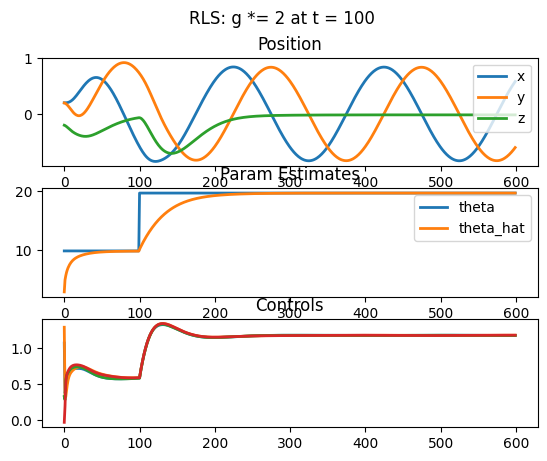

In [24]:
title = "RLS: g *= 2 at t = 100"
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_RLS(x0, xg, uhover, lqr_controller, circle_traj)
visualize_trajectory_with_theta(x_lqr, u_lqr, theta_hat, theta, title)

history cleared at  70  b/c the two guesses are  10.231341757256404 6.3871422676641245
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tolerance hit
tol

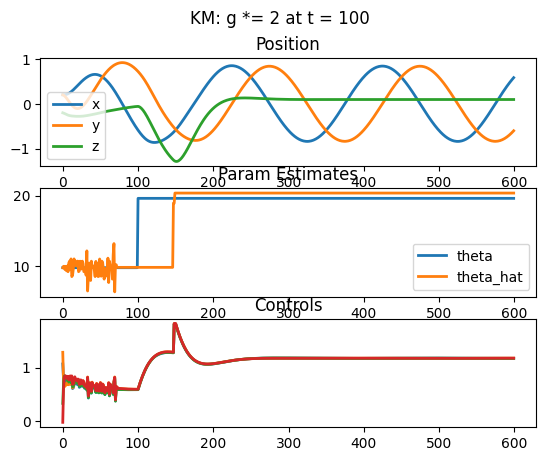

In [25]:
title = "KM: g *= 2 at t = 100"
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_RK(x0, xg, uhover, lqr_controller, circle_traj)
visualize_trajectory_with_theta(x_lqr, u_lqr, theta_hat, theta, title)

In [180]:
title = "Entropy KM: g *= 2 at t = 100"
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_entropy_RK(x0, xg, uhover, lqr_controller, circle_traj)
visualize_trajectory_with_theta(x_lqr, u_lqr, theta_hat, theta, title)

> /var/folders/3x/kdk7hgtn66xg9gtjw1kbk4r40000gn/T/ipykernel_7211/386138186.py(8)entropy_score()
      6     import pdb; pdb.set_trace()
      7     # Convert deque lists into proper numpy arrays
----> 8     df_dg_window = np.vstack(df_dg_window)  # Shape (num_samples, 13)
      9     b_window = np.vstack(b_window)  # Shape (num_samples, 13)
     10 



[[ 0.    ]
 [ 0.    ]
 [-0.0002]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [-0.02  ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]] [[ 0.    ]
 [ 0.002 ]
 [-0.    ]
 [ 0.0003]
 [-0.0006]
 [ 0.0172]
 [ 0.0152]
 [ 0.0009]
 [ 0.1959]
 [-0.0078]
 [-0.1127]
 [ 4.5755]
 [-0.2725]]
0.11085382360408336
dg=  0.11085382360408336
[[ 0.    ]
 [ 0.    ]
 [-0.0002]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [-0.02  ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]] [[ 0.0001]
 [-0.0021]
 [ 0.0004]
 [-0.0296]
 [ 0.0481]
 [-0.0127]
 [-0.0127]
 [ 0.0164]
 [-0.2068]
 [ 0.0525]
 [11.2594]
 [-3.7084]
 [ 0.0438]]
-0.47249745409567334
dg=  -0.47249745409567334
[[ 0.    ]
 [ 0.    ]
 [-0.0002]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [-0.02  ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]] [[-0.    ]
 [-0.    ]
 [-0.0001]
 [-0.0053]
 [ 0.011 ]
 [-0.0025]
 [-0.0026]
 [-0.0005]
 [-0.001 ]
 [-0.0111]
 [ 2.4264]
 [-0.755 ]
 [ 0.0038]]
-0.3713174940155508
dg=  -0.3713174940155508

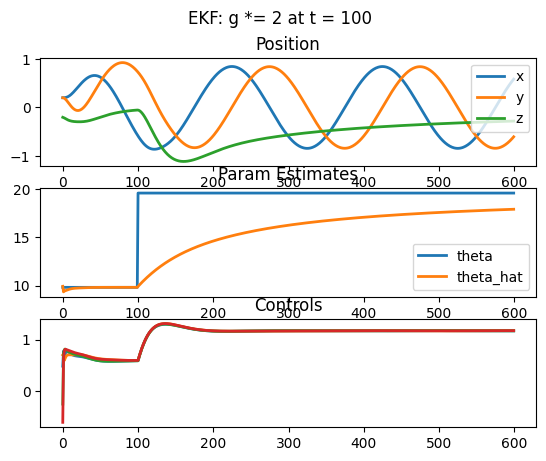

In [29]:
title = "EKF: g *= 2 at t = 100"
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_EKF(x0, xg, uhover, lqr_controller, circle_traj)
visualize_trajectory_with_theta(x_lqr, u_lqr, theta_hat, theta, title)